<h1><center> ASDS 5303 Final Project Assignment #4 Dataset 1: Drug SMILES Strings and Classifications - Different Optimizers </center></h1>

## Group Members
### Henry Berrios #1001392315
### LeMaur Kydd #1001767382

In [ ]:
# importing libraries (same as previous assignments, partially filled by google colab autofill)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pandas as pd
import numpy as np
from scipy.io import wavfile
import time

import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from google.colab import drive

# **A. Creating a Deep Neural Network and Optimizing Network Depth and Width (From Assignment 3)**

In [ ]:
# using cuda if we can
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# loading pre processed data
mounth_drive = '/content/drive'
drive.mount(mounth_drive)

X_train = torch.load('/content/drive/MyDrive/X_train_tensor_d1.pt').to(device)
X_test = torch.load('/content/drive/MyDrive/X_test_tensor_d1.pt').to(device)
y_train = torch.load('/content/drive/MyDrive/y_train_tensor_d1.pt').to(device)
y_test = torch.load('/content/drive/MyDrive/y_test_tensor_d1.pt').to(device)

Mounted at /content/drive


In [ ]:
# checking shape of tensors
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([5548, 399, 128])
torch.Size([5548, 5])
torch.Size([1387, 399, 128])
torch.Size([1387, 5])


In [ ]:
# defining a neural network (debugging assisted by OpenAI's ChatGPT)
class DeepNetwork(nn.Module):
  def __init__(self, input_size, hidden_layers, hidden_units, output_size):
    super(DeepNetwork, self).__init__()
    layers = []
    layers.append(nn.Linear(input_size, hidden_units))
    layers.append(nn.ReLU())

    for _ in range(hidden_layers - 1):
      layers.append(nn.Linear(hidden_units, hidden_units))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_units, output_size))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x = x.view(x.size(0), -1) # flattens the output
    return self.model(x)

In [ ]:
# testing on small sample
sample_inputs = X_train[:100].to(device)

In [ ]:
# passing through the model
deep_test_model = DeepNetwork(input_size = sample_inputs.shape[1] * sample_inputs.shape[2], hidden_layers = 2, hidden_units = 128, output_size = y_train.shape[1]).to(device)

sample_output = deep_test_model(sample_inputs)

print(sample_output.shape)

torch.Size([100, 5])


In [ ]:
# checking for training errors (large portions of code are autofilled by google colab's gemini)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_test_model.parameters(), lr=0.001)

sample_train = y_train[:100].to(device)
optimizer.zero_grad()
outputs = deep_test_model(sample_inputs)
loss = criterion(outputs, sample_train)
loss.backward()
optimizer.step()

print(loss.item())

1.590869426727295


In [ ]:
# training on small sample (large portions of code are autofilled by google colab's gemini)
small_train_loader = DataLoader(TensorDataset(X_train[:10], y_train[:10]), batch_size=2, shuffle=True)

for epoch in range(10):
  deep_test_model.train()
  epoch_loss = 0

  for batch_x, batch_y in small_train_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    optimizer.zero_grad()

    outputs = deep_test_model(batch_x)
    loss = criterion(outputs, batch_y)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(small_train_loader)}")

Epoch 1, Loss: 9.276565075665712
Epoch 2, Loss: 5.6124705374240875
Epoch 3, Loss: 3.936812510713935
Epoch 4, Loss: 3.559681683778763
Epoch 5, Loss: 0.7674056708812713
Epoch 6, Loss: 0.626580173894763
Epoch 7, Loss: 0.4207713872152453
Epoch 8, Loss: 0.12539518028497695
Epoch 9, Loss: 0.07854308672249317
Epoch 10, Loss: 0.032095400337129834


### **Optimizing Network Depth and Width**

In [ ]:
# optimizing network depth and width (large portions of code are autofilled by google colab's gemini)
def train_deep_model(model, train_loader, test_loader, epochs = 20, lr = 0.001):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = []
  for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      optimizer.zero_grad()
      outputs = model(batch_x)
      loss = criterion(outputs, batch_y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
      for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

  return train_losses, test_losses

In [ ]:
# testing optimization
batch_size = 256 # trying different batch sizes

In [ ]:
# creating dataset to use for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# creating dataloaders for batch processing
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# experimenting with depths and widths
hidden_layers_list = [1, 2, 3]
hidden_units_list = [32, 64, 128]

In [ ]:
# initializing variables to track best model configuration
best_loss = float('inf')
best_config = None

In [ ]:
# storing results for comparison
results = []

In [ ]:
# looping through different model configurations to find the best one (large portions of code are autofilled by google colab's gemini)
for hidden_layers in hidden_layers_list:
  for hidden_units in hidden_units_list:
    print(f"Training model with {hidden_layers} hidden layers and {hidden_units} hidden units")
    deep_model = DeepNetwork(input_size = X_train.shape[1] * X_train.shape[2], hidden_layers = hidden_layers, hidden_units = hidden_units, output_size = y_train.shape[1]).to(device)
    train_losses, test_losses = train_deep_model(deep_model, train_loader, test_loader, epochs = 5, lr = 0.001)

    final_test = test_losses[-1]
    results.append((hidden_layers, hidden_units, final_test))

    if final_test < best_loss:
      best_loss = final_test
      best_config = (hidden_layers, hidden_units)

Training model with 1 hidden layers and 32 hidden units
Epoch 1, Train Loss: 3.223003853451122, Test Loss: 1.5412701964378357
Epoch 2, Train Loss: 1.493269530209628, Test Loss: 1.5081941882769268
Epoch 3, Train Loss: 1.452307034622539, Test Loss: 1.4742813507715862
Epoch 4, Train Loss: 1.4036234400489114, Test Loss: 1.4459049503008525
Epoch 5, Train Loss: 1.3859049894592979, Test Loss: 1.4462852279345195
Training model with 1 hidden layers and 64 hidden units
Epoch 1, Train Loss: 5.211668984456495, Test Loss: 1.609748899936676
Epoch 2, Train Loss: 1.5609282417730852, Test Loss: 1.551754077275594
Epoch 3, Train Loss: 1.4926316954872825, Test Loss: 1.5199906428654988
Epoch 4, Train Loss: 1.4425663243640552, Test Loss: 1.4803263545036316
Epoch 5, Train Loss: 1.4036273251880298, Test Loss: 1.454499880472819
Training model with 1 hidden layers and 128 hidden units
Epoch 1, Train Loss: 6.111560512672771, Test Loss: 1.962656577428182
Epoch 2, Train Loss: 1.4715381210500544, Test Loss: 1.37098

KeyboardInterrupt: 

In [ ]:
# printing results to find the simplest model
best_loss = best_loss * 1.05

# sort by the layers and units for the simplest model
sort_results = sorted(results, key=lambda x: (x[0], x[1]))

# finding the simplest model that is within the threshold
for hidden_layers, hidden_units, test_loss in sort_results:
  if test_loss <= best_loss:
   simplest_config = (hidden_layers, hidden_units)
   simplest_loss = test_loss
   break

# printing results
print(f"The simplest model has {simplest_config[0]} hidden layer(s) and {simplest_config[1]} hidden units")

The simplest model has 1 hidden layer(s) and 128 hidden units


In [ ]:
# definining the function to evaluate the model
def evaluate_model(model, test_loader):
  model.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
    for batch_x, batch_y in test_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      outputs = model(batch_x)
      _, predicted = torch.max(outputs, 1)

      y_true.extend(batch_y.argmax(dim=1).cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

    # commpting metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    # printing results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1, conf_matrix

In [ ]:
# loading the best model
best_model = DeepNetwork(input_size = X_train.shape[1] * X_train.shape[2], hidden_layers = best_config[0], hidden_units = best_config[1], output_size = y_train.shape[1]).to(device)

In [ ]:
# retraining the best model
train_losses, test_losses = train_deep_model(best_model, train_loader, test_loader, epochs = 5, lr = 0.001)

# evaluate the best model
evaluate_model(best_model, test_loader)

Epoch 1, Train Loss: 6.535926585847681, Test Loss: 1.6141885320345561
Epoch 2, Train Loss: 1.5961132753979077, Test Loss: 1.5005433758099873
Epoch 3, Train Loss: 1.449593717401678, Test Loss: 1.4516608516375225
Epoch 4, Train Loss: 1.3908334103497593, Test Loss: 1.436609109242757
Epoch 5, Train Loss: 1.3889574733647434, Test Loss: 1.4583584864934285
Accuracy: 0.3843
Precision: 0.3857
Recall: 0.3843
F1 Score: 0.2967


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.384282624369142,
 0.3857057841785609,
 0.384282624369142,
 0.29668598509552574,
 array([[361,   0,   0,   3, 115],
        [153,   1,   0,   4,  77],
        [ 99,   0,   0,   9,  50],
        [150,   1,   0,  27,  50],
        [139,   0,   0,   4, 144]]))

# **B. Gradient Descent (GD)**

In [ ]:
# using the full dataset as a single batch (gradinet descent)
gd_loader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = True)

In [ ]:
# intializing the model
gd_model = DeepNetwork(input_size = X_train.shape[1] * X_train.shape[2],
                       hidden_layers = best_config[0],
                       hidden_units = best_config[0],
                       output_size = y_train.shape[1]).to(device)

In [ ]:
# loss function cross entropy for multi-class classification
criterion = nn.CrossEntropyLoss()

In [ ]:
# optimizer using vanilla gradinet descent (single full batch)
optimizer = optim.SGD(gd_model.parameters(), lr = 0.001)

In [ ]:
# training the model and timing it
start_time = time.time()
train_losses, test_losses = train_deep_model(gd_model, gd_loader, test_loader, epochs = 5, lr = 0.01)
end_time = time.time()

In [ ]:
# record and print training duration
gd_time = end_time - start_time
print(f"Training time: {gd_time} seconds")

In [ ]:
# evaluate model on test data
gd_accuracy, _, _, _, _ = evaluate_model(gd_model, test_loader)

In [ ]:
# plot test accuracies vs batch sizes

plt.figure()
plt.plot(batch_size, sgd_results, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Batch Size (GD)')
plt.grid(True)
plt.show()

# **C. Stochastic Gradient Descent (SGD)**

In [ ]:
# creating a list of batch sizes (full batch, 1/2, 1/4 and so on)
batch_size = [len(train_dataset) // (2 ** i) for i in range(3)]
sgd_results = []

In [ ]:
# looping over each batch size
for bs in batch_size:
  print(f"Training model with batch size {bs}")

  # creating a DataLoader with the given batch size
  sgd_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True)

  # intializing the model for each individual run
  sgd_model = DeepNetwork(input_size = X_train.shape[1] * X_train.shape[2],
                          hidden_layers = best_config[0],
                          hidden_units = best_config[1],
                          output_size = y_train.shape[1]).to(device)

  # time it takes to train
  start_time = time.time()
  train_losses, test_losses = train_deep_model(sgd_model, sgd_loader, test_loader, epochs = 3, lr = 0.01)
  end_time = time.time()

  # evaluate the model and store the results
  sgd_time = end_time - start_time
  print(f"Training time: {sgd_time} seconds")
  accuracy, _, _, _, _ = evaluate_model(sgd_model, test_loader)

  sgd_results.append({'Batch_size': bs, 'Training Time': sgd_time, 'Accuracy': accuracy, 'loss': test_losses[-1]})


Training model with batch size 5548
Epoch 1, Train Loss: 1.6439422369003296, Test Loss: 660.0360107421875
Epoch 2, Train Loss: 662.5369262695312, Test Loss: 133.62443923950195
Epoch 3, Train Loss: 134.09613037109375, Test Loss: 29.22572962443034
Training time: 317.3909010887146 seconds
Accuracy: 0.1204
Precision: 0.2379
Recall: 0.1204
F1 Score: 0.0362
Training model with batch size 2774


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 335.0934924483299, Test Loss: 207.15882873535156
Epoch 2, Train Loss: 154.01274490356445, Test Loss: 31.046780904134113
Epoch 3, Train Loss: 39.667582511901855, Test Loss: 45.42159334818522
Training time: 321.1830315589905 seconds
Accuracy: 0.3453
Precision: 0.1193
Recall: 0.3453
F1 Score: 0.1773
Training model with batch size 1387


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 334.2948656976223, Test Loss: 66.10553232828777
Epoch 2, Train Loss: 49.34764862060547, Test Loss: 24.23406155904134
Epoch 3, Train Loss: 9.63357987999916, Test Loss: 1.6959721247355144
Training time: 327.67606949806213 seconds
Accuracy: 0.2300
Precision: 0.4865
Recall: 0.2300
F1 Score: 0.1292


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


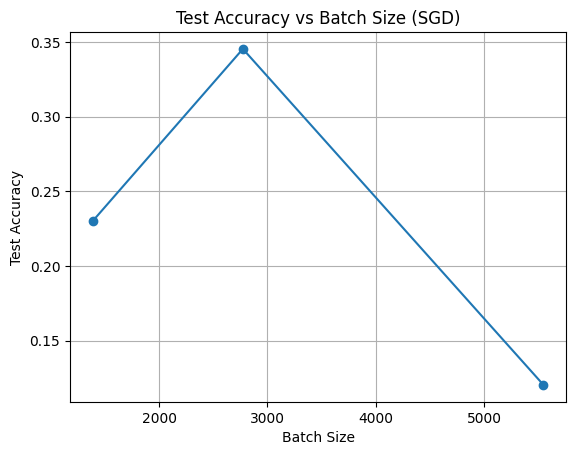

In [ ]:
# plot test accuracies vs batch sizes

plt.figure()
plt.plot(batch_size, [i['Accuracy'] for i in sgd_results], marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Batch Size (SGD)')
plt.grid(True)
plt.show()

# **D. SGD with Momentum**

In [ ]:
# various portions of this code block were filled in with autofill AI

batch_sizes = [len(train_dataset) // (2 ** i) for i in range(3)]
momentum_results = []

In [ ]:
# various portions of this code block were filled in with autofill AI

# looping over batch sizes
for batch_size in batch_sizes:
  gd_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

  gd_model = DeepNetwork(
      input_size = X_train.shape[1] * X_train.shape[2],
      hidden_layers = best_config[0],
      hidden_units = best_config[1],
      output_size = y_train.shape[1]
  ).to(device)

  # define loss and SGD with momentum optim
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(gd_model.parameters(), lr = 0.01, momentum = 0.9)

  # train
  start_time = time.time()
  train_losses, test_losses = train_deep_model(gd_model, gd_loader, test_loader, epochs = 3, lr = 0.01)
  end_time = time.time()
  print(f"Batch Size: {batch_size}. Training time: {end_time - start_time:.2f} sec")

  # evaluate and keep test accuracies
  gd_accuracy, _, _, _, _ = evaluate_model(gd_model, test_loader)
  momentum_results.append(gd_accuracy)

Epoch 1, Train Loss: 1.6156363487243652, Test Loss: 185.00637817382812
Epoch 2, Train Loss: 184.79823303222656, Test Loss: 45.3327833811442
Epoch 3, Train Loss: 45.04075622558594, Test Loss: 30.056878089904785
Batch Size: 5548. Training time: 58.27 sec
Accuracy: 0.2069
Precision: 0.0428
Recall: 0.2069
F1 Score: 0.0710


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 56.466901242733, Test Loss: 23.812867800394695
Epoch 2, Train Loss: 16.866329669952393, Test Loss: 15.450675328572592
Epoch 3, Train Loss: 12.622387409210205, Test Loss: 3.551694313685099
Batch Size: 2774. Training time: 60.97 sec
Accuracy: 0.3453
Precision: 0.1193
Recall: 0.3453
F1 Score: 0.1773


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 40.81751376390457, Test Loss: 10.456514040629068
Epoch 2, Train Loss: 5.364628553390503, Test Loss: 1.6431031425793965
Epoch 3, Train Loss: 1.5992931425571442, Test Loss: 1.5364420016606648
Batch Size: 1387. Training time: 66.68 sec
Accuracy: 0.3064
Precision: 0.2937
Recall: 0.3064
F1 Score: 0.2591


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


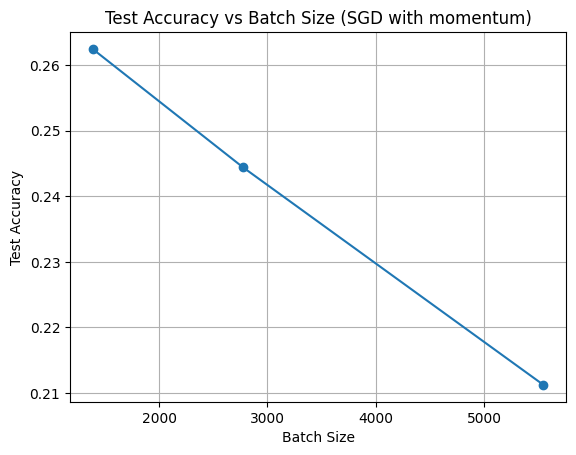

In [ ]:
# plot test accuracies vs batch sizes

plt.figure()
plt.plot(batch_sizes, momentum_results, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Batch Size (SGD with momentum)')
plt.grid(True)
plt.show()